# Logistic Regression

In [1]:
import pandas as pd
import rdata
from sklearn.linear_model import LogisticRegression
import json
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import StratifiedKFold
import numpy as np
from functions import get_cv_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import itertools

import seaborn as sns


## Data

In [2]:

# df_wfc = pd.read_pickle("../data/df_uni_bi_tri_normalized.pickle")
# df =df_wfc.reset_index(col_level=1).rename(columns = {'': 'id'}, level =0)

df_sc = pd.read_pickle("../data/df_uni_bi_tri_normalized_SC.pickle")
df_ic = pd.read_pickle("../data/df_uni_bi_tri_normalized_IC.pickle")
df = df_sc.merge(df_ic, on = 'uniform_id')
df =df.reset_index(col_level=1).rename(columns = {'': 'id'}, level =0)

# df basline:
# df_baseline = pd.read_pickle("../data/df_baseline.pickle")
# df =df_baseline.reset_index(col_level=1).rename(columns = {'': 'id'}, level =0)

In [3]:
df.head()


id TF_uni_POS                                                    \
  uniform_id        ADJ       ADP       ADV       AUX     CCONJ       DET   
0       ee_1   0.092952  0.021455  0.068043  0.039998  0.024544  0.025583   
1      ee_12   0.098369  0.036429  0.055563  0.032016  0.009287  0.019285   
2      ee_16   0.090635  0.023712  0.068675  0.038582  0.024094  0.020737   
3      ee_19   0.088778  0.017851  0.059174  0.045878  0.024351  0.029278   
4       ee_2   0.089408  0.022145  0.058950  0.048772  0.012299  0.023303   

                                 ... FF_tri_IC                                \
       NOUN       NUM      PART  ...        21        22        23        24   
0  0.069455  0.162422  0.023479  ...  0.172410  0.168674  0.176803  0.271371   
1  0.071990  0.131555  0.045870  ...  0.153643  0.168770  0.172643  0.447568   
2  0.077147  0.134208  0.036140  ...  0.169928  0.177039  0.168858  0.243441   
3  0.070724  0.106533  0.031707  ...  0.131176  0.126908  0.155958  0.312220   
4  0.082544  0.021347  0.030941  ...  0.196307  0.171843  0.210000  0.280437   

                                                               
         25        26        27        28        30        31  
0  0.263921  0.179121  0.152872  0.122909  0.174318  0.176566  
1  0.384881  0.195568  0.280024  0.093657  0.275122  0.191923  
2  0.298895  0.218182  0.117245  0.131791  0.153952  0.238349  
3  0.218795  0.161457  0.149022  0.104540  0.084703  0.136146  
4  0.285829  0.284697  0.304705  0.182424  0.184710  0.248796  

[5 rows x 5293 columns]

Add language that is going to be the label/ target for model:

In [4]:
# read df with language:
path_ind_diff = r"../data/version 1.1/primary data/individual differences data/joint.ind.diff.l2.rda"
parsed_readrate = rdata.parser.parse_file(path_ind_diff)
converted_readrate = rdata.conversion.convert(parsed_readrate)
df_readrate = converted_readrate['joint_id'][['uniform_id', 'lang']]

df_readrate['lang'] = df_readrate['lang'].replace(['ge'], 'de')
df_readrate['lang'] = df_readrate['lang'].replace(['ee'], 'et')
df_readrate['lang'] = df_readrate['lang'].replace(['sp'], 'es')

# need multiindex to merge properly:
df_readrate.columns = pd.MultiIndex.from_product([['labels'], df_readrate.columns]) 

# join language
df_main = df.merge(df_readrate, left_on = [('id', 'uniform_id')], right_on= [('labels', 'uniform_id')])
df_main = df_main.drop([('labels', 'uniform_id')], axis=1)

# encode language as lables ( using old lookup json):
with open("../data/outputs/language_lookup.json") as json_file:
    language_lookup = json.load(json_file)

df_main[('labels', 'lang_code')] = df_main[('labels', 'lang')].replace(language_lookup).values

/tmp/ipykernel_638/3035105660.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_readrate['lang'] = df_readrate['lang'].replace(['ge'], 'de')
/tmp/ipykernel_638/3035105660.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_readrate['lang'] = df_readrate['lang'].replace(['ee'], 'et')
/tmp/ipykernel_638/3035105660.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [5]:
df_main[('labels', 'lang')].value_counts()

et    23
fi    23
de    23
en    21
es    21
it    20
he    18
Name: (labels, lang), dtype: int64

## Columns (define columns to train on)

In [6]:
# columns used in training
# df_main.columns.get_level_values(0).unique()

#columns = [ 'TF_uni_WFC', 'FP_uni_WFC', 'FF_uni_WFC', 'TF_bi_WFC', 'FP_bi_WFC', 'FF_bi_WFC', 'TF_tri_WFC', 'FP_tri_WFC', 'FF_tri_WFC']


columns = [ 
'TF_uni_POS', 'FP_uni_POS', 'FF_uni_POS',
#'TF_bi_POS', 'FP_bi_POS', 'FF_bi_POS',
#'TF_tri_POS', 'FP_tri_POS', 'FF_tri_POS',
'TF_uni_PTB', 'FP_uni_PTB', 'FF_uni_PTB',
#'TF_bi_PTB', 'FP_bi_PTB', 'FF_bi_PTB',
#'TF_tri_PTB', 'FP_tri_PTB', 'FF_tri_PTB',
'TF_uni_UD', 'FP_uni_UD', 'FF_uni_UD',
#'TF_bi_UD', 'FP_bi_UD', 'FF_bi_UD',
#'TF_tri_UD', 'FP_tri_UD', 'FF_tri_UD',
 
#columns = [       
  'TF_uni_IC', 'FP_uni_IC', 'FF_uni_IC', 
  #'TF_bi_IC', 'FP_bi_IC', 'FF_bi_IC', 
  #'TF_tri_IC', 'FP_tri_IC', 'FF_tri_IC'
    ]

#columns=['TF', 'FP', 'FF']

## Performance graph

In [52]:
#only for 4 lang check:
#df_main = df_main[df_main[('labels', 'lang')].isin(['ee', 'fi', 'it', 'sp'])]

dict_performances = {}
dict_performances_groups = []

for i in range(2, 8): # 8
    comb = list(itertools.combinations(['ee', 'fi', 'ge', 'he', 'it', 'en', 'sp'], i))
    temp = []
    for c in comb:
        df_main_ = df_main[df_main[('labels', 'lang')].isin(c)]
        logreg = LogisticRegression(C=1e5, multi_class='multinomial', solver='lbfgs', random_state=0, max_iter = 2000)
        cross_val_scores = get_cv_score(df_main_, columns, logreg)
        dict_performances[str(c)] = np.mean(cross_val_scores)
        temp.append(np.mean(cross_val_scores))
    dict_performances_groups.append([i, np.mean(temp)])

10it [00:04,  2.02it/s]
10it [00:05,  1.78it/s]
10it [00:04,  2.14it/s]
10it [00:04,  2.17it/s]
10it [00:03,  2.54it/s]
10it [00:04,  2.07it/s]
10it [00:04,  2.10it/s]
10it [00:04,  2.16it/s]
10it [00:04,  2.20it/s]
10it [00:01,  6.61it/s]
10it [00:01,  5.39it/s]
10it [00:01,  5.56it/s]
10it [00:02,  4.55it/s]
10it [00:02,  4.60it/s]
10it [00:01,  6.14it/s]
10it [00:01,  6.97it/s]
10it [00:01,  5.24it/s]
10it [00:02,  4.48it/s]
10it [00:04,  2.31it/s]
10it [00:04,  2.02it/s]
10it [00:04,  2.32it/s]
10it [00:04,  2.16it/s]
10it [00:08,  1.19it/s]
10it [00:07,  1.40it/s]
10it [00:05,  1.97it/s]
10it [00:05,  1.76it/s]
10it [00:05,  1.77it/s]
10it [00:05,  1.68it/s]
10it [00:05,  1.97it/s]
10it [00:04,  2.06it/s]
10it [00:05,  1.69it/s]
10it [00:05,  1.75it/s]
10it [00:07,  1.42it/s]
10it [00:05,  1.73it/s]
10it [00:05,  1.72it/s]
10it [00:05,  1.75it/s]
10it [00:07,  1.37it/s]
10it [00:08,  1.23it/s]
10it [00:05,  1.74it/s]
10it [00:07,  1.39it/s]
10it [00:03,  2.78it/s]
10it [00:01,  5.

In [53]:
# dict_performances
# dict_performances_groups_uni = dict_performances_groups
# print(dict_performances_groups_tri)
# print(dict_performances_groups_bi)
# print(dict_performances_groups_uni)




dict_performances_groups_scic = dict_performances_groups
dict_performances_groups

[[2, 0.9296825396825397],
 [3, 0.8746802721088435],
 [4, 0.8332142857142857],
 [5, 0.8053535353535354],
 [6, 0.781004709576138],
 [7, 0.7795238095238095]]

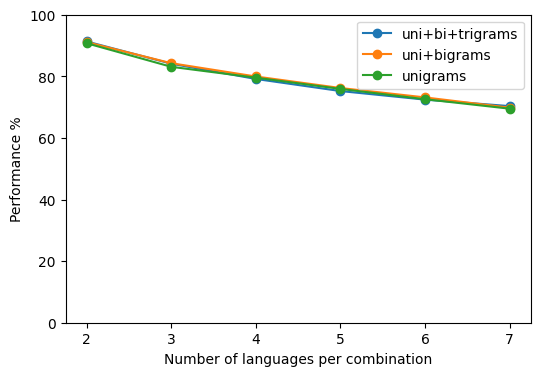

In [25]:
fig, axes = plt.subplots(ncols=1, figsize=(6,4))
axes.plot(np.array(dict_performances_groups_tri)[:, 0],
        [i * 100 for i in  np.array(dict_performances_groups_tri)[:, 1]], marker='o', label = 'uni+bi+trigrams')
axes.plot(np.array(dict_performances_groups_bi)[:, 0],
        [i * 100 for i in  np.array(dict_performances_groups_bi)[:, 1]], marker='o', label = 'uni+bigrams')
axes.plot(np.array(dict_performances_groups_uni)[:, 0],
        [i * 100 for i in  np.array(dict_performances_groups_uni)[:, 1]], marker='o', label = 'unigrams')
# mean performance per group of all combinations of languages
#axes.set_title(' Mean performance per group of all possible combinations of languages. E.g. 2 on the x axis means a group all language pairs amd y shows the mean performance.')
axes.legend()
axes.set_xlabel('Number of languages per combination')
axes.set_ylabel('Performance %')
axes.set_ylim(0, 100);

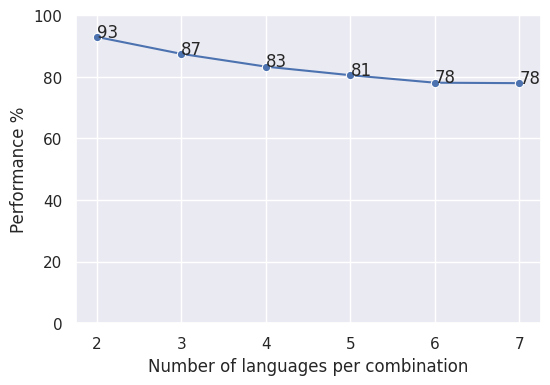

In [56]:
xx = np.array(dict_performances_groups)[:, 0]
yy = [i * 100 for i in  np.array(dict_performances_groups)[:, 1]]

sns.set_theme()
fig, axes = plt.subplots(ncols=1, figsize=(6,4))
#axes.plot(xx, yy, marker='o', label = 'uni+bi+trigrams')
sns.lineplot(x=xx, y=yy, marker='o') #, label = 'uni+bi+trigrams'
# mean performance per group of all combinations of languages
#axes.set_title(' Mean performance per group of all possible combinations of languages. E.g. 2 on the x axis means a group all language pairs amd y shows the mean performance.')
#axes.legend()
axes.set_xlabel('Number of languages per combination')
axes.set_ylabel('Performance %')
axes.set_ylim(0, 100);


for i, txt in enumerate(yy):
    axes.annotate(int(round(txt, 0)), (xx[i], yy[i]))

#     for i,j in zip(x,y):
#     ax.annotate(str(j),xy=(i,j))

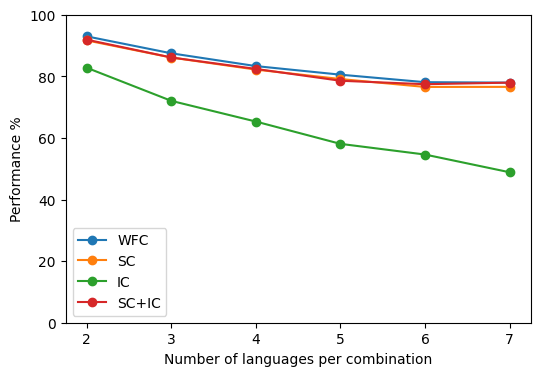

In [40]:
fig, axes = plt.subplots(ncols=1, figsize=(6,4))
axes.plot(np.array(dict_performances_groups_wfc)[:, 0],
        [i * 100 for i in  np.array(dict_performances_groups_wfc)[:, 1]], marker='o', label = 'WFC')
axes.plot(np.array(dict_performances_groups_sc)[:, 0],
        [i * 100 for i in  np.array(dict_performances_groups_sc)[:, 1]], marker='o', label = 'SC')
axes.plot(np.array(dict_performances_groups_ic)[:, 0],
        [i * 100 for i in  np.array(dict_performances_groups_ic)[:, 1]], marker='o', label = 'IC')
axes.plot(np.array(dict_performances_groups_scic)[:, 0],
        [i * 100 for i in  np.array(dict_performances_groups_scic)[:, 1]], marker='o', label = 'SC+IC')
# mean performance per group of all combinations of languages
#axes.set_title(' Mean performance per group of all possible combinations of languages. E.g. 2 on the x axis means a group all language pairs amd y shows the mean performance.')
axes.legend()
axes.set_xlabel('Number of languages per combination')
axes.set_ylabel('Performance %')
axes.set_ylim(0, 100);

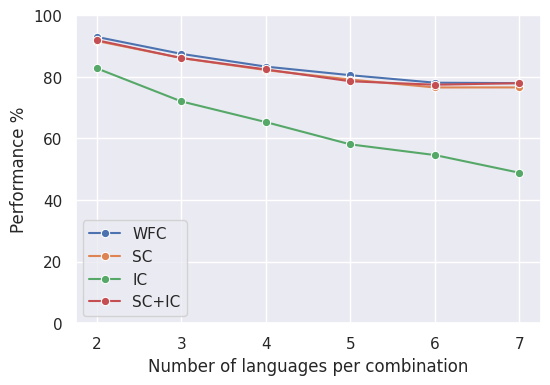

In [46]:
sns.set_theme()
#sns.lineplot(data=may_flights, x="year", y="passengers")

fig, axes = plt.subplots(ncols=1, figsize=(6,4))
sns.lineplot(x=np.array(dict_performances_groups_wfc)[:, 0],
        y=[i * 100 for i in  np.array(dict_performances_groups_wfc)[:, 1]], 
        marker='o', label = 'WFC', ax = axes)
sns.lineplot(x=np.array(dict_performances_groups_sc)[:, 0],
        y=[i * 100 for i in  np.array(dict_performances_groups_sc)[:, 1]],
        marker='o', label = 'SC')
sns.lineplot(x=np.array(dict_performances_groups_ic)[:, 0],
        y=[i * 100 for i in  np.array(dict_performances_groups_ic)[:, 1]],
        marker='o', label = 'IC')
sns.lineplot(x=np.array(dict_performances_groups_scic)[:, 0],
        y=[i * 100 for i in  np.array(dict_performances_groups_scic)[:, 1]],
        marker='o', label = 'SC+IC')

# mean performance per group of all combinations of languages
#axes.set_title(' Mean performance per group of all possible combinations of languages. E.g. 2 on the x axis means a group all language pairs amd y shows the mean performance.')
axes.legend()
axes.set_xlabel('Number of languages per combination')
axes.set_ylabel('Performance %')
axes.set_ylim(0, 100);


## LogReg NLIR

In [7]:
# defining model with correct solver
logreg = LogisticRegression(C=1e5, multi_class='multinomial', solver='lbfgs', random_state=0, max_iter = 2000)

Cross validation score: 

In [8]:
cross_val_scores = get_cv_score(df_main, columns, logreg)
print(np.mean(cross_val_scores))

10it [00:01,  6.33it/s]

0.5228571428571429


**NEW**

**WFC**
- uni - 0.8128571428571428
- uni+bi - 0.7928571428571429
- uni+bi+tri - 0.7795238095238095

**SC**
- uni - 0.5761904761904761
- uni+bi - 0.7328571428571429
- uni+bi+tri - 0.7657142857142857

**IC**
- uni - 0.47523809523809524
- uni+bi - 0.48190476190476195
- uni+bi+tri - 0.48857142857142855

**SC+IC**
- uni - 0.5228571428571429
- uni+bi - 0.7328571428571429
- uni+bi+tri - 0.7795238095238096

**OLD**

**WFC**
- uni - 0.695
- uni+bi - 0.6983333333333334
- uni+bi+tri - 0.7033333333333334

**SC**
- uni - 0.4766666666666667
- uni+bi - 0.6883333333333332
- uni+bi+tri - 0.71

**IC**
- uni - 0.40333333333333343
- uni+bi - 0.4166666666666667
- uni+bi+tri - 0.44833333333333336

**SC+IC**
- uni - 0.4916666666666667
- uni+bi - 0.6866666666666666
- uni+bi+tri - 0.6966666666666667

## LogReg Similarity

### Train_test split

In [8]:
train_subset = df_main[columns]
train_label_subset = df_main[('labels', 'lang_code')]
gss = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
split_indexes = list(gss.split(train_subset, train_label_subset))

In [9]:
lang_similarities_tables =[]
for i in range(10):
    split_index = split_indexes[i]
    train_idx = list(split_index[0])
    test_idx = list(split_index[1])

    X_train = train_subset.iloc[train_idx]
    y_train = train_label_subset.iloc[train_idx]
    X_test = train_subset.iloc[test_idx]
    y_test = train_label_subset.iloc[test_idx]

    test_lang = df_main[('labels', 'lang')].iloc[test_idx]
    test_lang_codes = df_main[('labels', 'lang_code')].iloc[test_idx]

    logreg.fit(X_train, y_train)
#--
    X_test['lang'] = test_lang # add target (language) column 
    languages = list(test_lang.unique())
    dict_lang = {}
    for ll in languages:
        df = X_test[X_test['lang'] == ll]
        dict_lang[ll] = df

    dict_proba ={}
    len_dfs = []
    lang_identifier = []
    for key in dict_lang.keys():
        lang_df = dict_lang[key][columns]
        test_proba = logreg.predict_proba(lang_df) # predicting probabilities here
        len_df = len(lang_df) # num participants for each language
        test_proba_sum = test_proba.sum(axis=0)   # sum bc they are normalised by number of participants
        dict_proba[key] = test_proba_sum
        len_dfs.append(len_df) # record length of language df
        lang_identifier.append(key)
#--
    # to pandas:
    df_predictions = pd.DataFrame(dict_proba).reset_index()
    # cols are lang on which predicted and rows are outputs

    # add col with lenghts and lang name
    df_predictions['length'] = len_dfs
    df_predictions['lang'] = lang_identifier
#--
    lang_values = []
    lang_pairs = []
    #lang_similarities = {}
    for key1 in df_predictions['lang'].unique(): 
        for key2 in df_predictions['lang'].unique(): 
            val1 = float(df_predictions[df_predictions['lang'] == key1][key2])
            val2 = float(df_predictions[df_predictions['lang'] == key2][key1])
            len1 = float(df_predictions[df_predictions['lang'] == key1]['length'])
            len2 = float(df_predictions[df_predictions['lang'] == key2]['length'])
            
            #lang_similarities[f'{key1}_{key2}'] = ((val1 + val2) /(len1+len2)) #  divide by corpus length bc summed above
            lang_values.append((val1 + val2) / (len1+len2))
            lang_pairs.append(f'{key1}_{key2}')
#--
    df_lang_similarities = pd.DataFrame({'pair': lang_pairs, 'logreg_val': lang_values})
    # inverted 
    df_lang_similarities['logreg_val_inverted'] = 1 - df_lang_similarities['logreg_val']

    lang_similarities_tables.append(df_lang_similarities)


/tmp/ipykernel_638/2781699200.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['lang'] = test_lang # add target (language) column
/tmp/ipykernel_638/2781699200.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['lang'] = test_lang # add target (language) column
/tmp/ipykernel_638/2781699200.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

In [13]:
df_lang_similarities = pd.concat(lang_similarities_tables, axis=0).groupby('pair').mean().reset_index()

In [14]:
df_lang_similarities

,pair,logreg_val,logreg_val_inverted
0,de_de,0.715413,0.284587
1,de_en,0.008112,0.991888
2,de_es,0.071600,0.928400
3,de_et,0.022746,0.977254
4,de_fi,0.083683,0.916317
5,de_he,0.126257,0.873743
6,de_it,0.054699,0.945301
7,en_de,0.008112,0.991888
8,en_en,0.922504,0.077496
9,en_es,0.007091,0.992909


In [15]:
# write 

df_lang_similarities.to_csv("../data/outputs/logreg_similarity_SC_IC_uni_new.csv", index = False) # rename for other saves

**ToDos:**

- investigate why 4 lang perform worse than all. maybe try with 2? ( very different and very similar - eg ee vs fi and ee and sp)
- do separate runs with only bi and bi+tri-grams and fill table in report
- plot language tree using both similarity metrics
- do majority class baseline (cv accuracy only)

